#### Navigate to folder containing .mat files. Specifically NPR-075.b11.mat

In [1]:
cd ../_data/matlabData/

/home/gustav/Documents/DD142X/code/_data/matlabData


#### Function definitions, read channel data

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from h5py import File
def getMatlabValues(fileName):
    with File(fileName, "r") as data:
        return {
            key: np.array(data[key]["values"]).flatten() for key in data.keys()
        }

# Fourier Feature Vector
def ffv(xs, Fs = 16000., epoch_size = 2 ** 11, fft_n = 2 ** 14):

    # Pad with zeroes for more frequency outputs
    # Compare np.fft.fftfreq(n, 1/16000) for n = 2**11, 2**14
    fft_in = np.zeros((xs.shape[0], fft_n))
    fft_in[ : , 0:epoch_size] = xs

    frqs = np.fft.fftfreq(fft_n, 1./Fs)
    lo = np.where(frqs > 12)[0][0]
    hi = np.where(frqs > 30)[0][0]
    fftxs = np.abs(np.fft.fft(fft_in)[:,lo:hi])

    return fftxs, frqs[lo:hi]

In [3]:
mlvals = getMatlabValues("NPR-075.b11.mat")

# Magic number "775": 
# Known since earlier that 775 epochs of size 2**11 fit in these channels
magic_max = 775 * 2**11
# Trim down to size when loading
str_channels = np.array([ v[0 : magic_max] for k, v in mlvals.items() if "str_lfp" in k])
gp_channels  = np.array([ v[0 : magic_max] for k, v in mlvals.items() if "gp_lfp"  in k])
all_channels = np.concatenate((str_channels, gp_channels), axis = 0)

print(str_channels.shape)
print(gp_channels.shape)
print(all_channels.shape)

(11, 1587200)
(15, 1587200)
(26, 1587200)


At this point, we've loaded all of the striatum and globus pallidus LFP channels.
We have them sorted by type, and as one large array.

#### Sidenote on ffv function.

ffv uses a Discrete Fourier Transform to generate a feature vector.
It returns amplitude measures for outputs in the beta-range (here, 12-30 Hz).
By adjusting fft_n, we can get more features in our output.

In [4]:
# Our sampling frequency is always 16 kHz.
Fs = 16000.

# np.fft.fftfreq allows index-to-frequency mappings.
# It takes n (amount of points) and d (1 / Fs)
some_sample_frequencies = np.fft.fftfreq(2 ** 11, d = 1. / Fs)
# The indexing of np.where output is a bit messy.
lo_frequencies = np.where(some_sample_frequencies > 12)[0][0]
hi_frequencies = np.where(some_sample_frequencies > 30)[0][0]
# These are indexes.
print(lo_frequencies)
print(hi_frequencies)
# These are frequencies available to us.
print(some_sample_frequencies[lo_frequencies : hi_frequencies])

2
4
[15.625  23.4375]


Only two features. Note that with epoch size (n) of 2 ** 11, our epoch length is just:

In [5]:
2 ** 11 / Fs * 1000

128.0

128 ms. But, we can be smarter than this. By padding the input with zeros (this is what we do when we increase fft_n in ffv), we can get much richer output.

In [6]:
# Same as above, but 2 ** 14 instead of 2 ** 11.
some_sample_frequencies = np.fft.fftfreq(2 ** 14, d = 1. / Fs)

lo_frequencies = np.where(some_sample_frequencies > 12)[0][0]
hi_frequencies = np.where(some_sample_frequencies > 30)[0][0]

print(lo_frequencies)
print(hi_frequencies)

print(some_sample_frequencies[lo_frequencies : hi_frequencies])

13
31
[12.6953125 13.671875  14.6484375 15.625     16.6015625 17.578125
 18.5546875 19.53125   20.5078125 21.484375  22.4609375 23.4375
 24.4140625 25.390625  26.3671875 27.34375   28.3203125 29.296875 ]


This is much better as a feature vector. The output of ffv will have this shape (per row). ffv also returns a list of the frequencies, on the same form as the examples above. Note that by increasing fft_n, computation time increases quite significantly.

#### Purpose of this session is to produce data on these feature vectors.
The following cell is somewhat computation heavy.

In [7]:
epoch_size = 2 ** 11

str_ffv, _ = ffv(str_channels.reshape((-1, epoch_size)))
gp_ffv,  _ = ffv( gp_channels.reshape((-1, epoch_size)))
all_ffv, _ = ffv(all_channels.reshape((-1, epoch_size)))

print(str_ffv.shape)
print(gp_ffv.shape)
print(all_ffv.shape)

(8525, 18)
(11625, 18)
(20150, 18)


Consider the mean-vector and variance-vector of the feature vectors over different epochs.
This means taking the mean and variance of the feature vectors over different channels.

Currently, our arrays have shape (n_channels * n_epochs) x n_features.

In [8]:
# Magic constant
n_epochs = 775
# Amount of features with current epoch size, input to ffv, Fs
n_features = 18

# n_channels varies.
# 11 for str, 15 for gp, 26 in total.

# We'd like our arrays to be n_channels x n_epochs x n_features
str_ffv = str_ffv.reshape((-1, n_epochs, n_features))
gp_ffv  =  gp_ffv.reshape((-1, n_epochs, n_features))
all_ffv = all_ffv.reshape((-1, n_epochs, n_features))

print(str_ffv.shape)
print(gp_ffv.shape)
print(all_ffv.shape)

(11, 775, 18)
(15, 775, 18)
(26, 775, 18)


In [9]:
mean_str = str_ffv.mean(axis = 0)
std_str = str_ffv.std(axis = 0)

mean_gp = gp_ffv.mean(axis = 0)
std_gp = gp_ffv.std(axis = 0)

mean_all = all_ffv.mean(axis = 0)
std_all = all_ffv.std(axis = 0)

#### Example plot. Mean over str channels, first 100 epochs.
Plotting in Jupyter can have wierd side-effects. If something looks wrong, re-execute plotting code-cell.

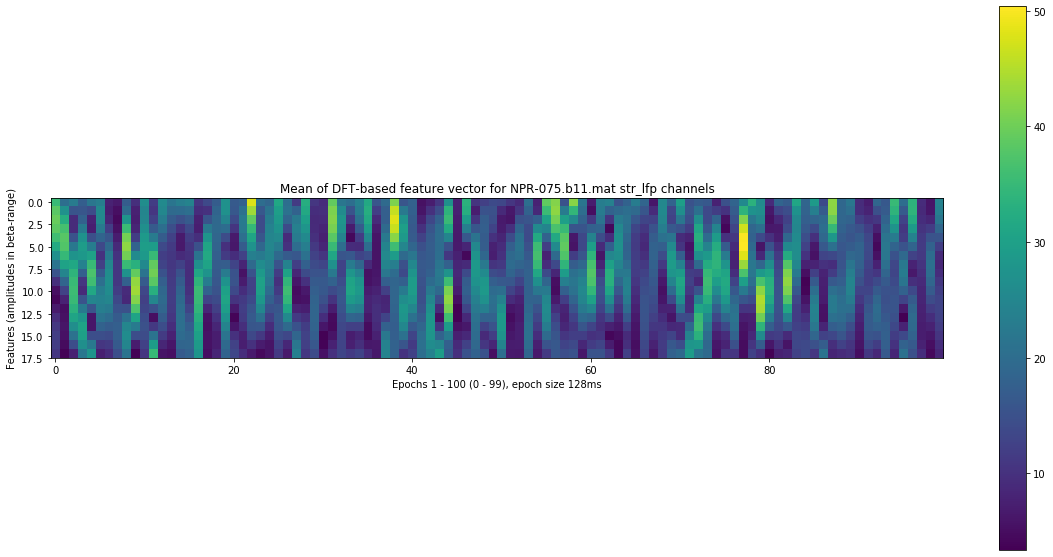

In [10]:
# It's easier to see time flowing left instead of down.
# It's a long array, let's just show some of it.
mean_str_plot = mean_str.transpose()[ : , 0 : 100]

plt.rcParams["figure.figsize"] = (20, 10)

plt.imshow(mean_str_plot)
plt.colorbar()
plt.title("Mean of DFT-based feature vector for NPR-075.b11.mat str_lfp channels")
plt.xlabel("Epochs 1 - 100 (0 - 99), epoch size 128ms")
plt.ylabel("Features (amplitudes in beta-range)")
plt.show()

#### The code below usually requires two executions, or the plots become too small. I don't know why.

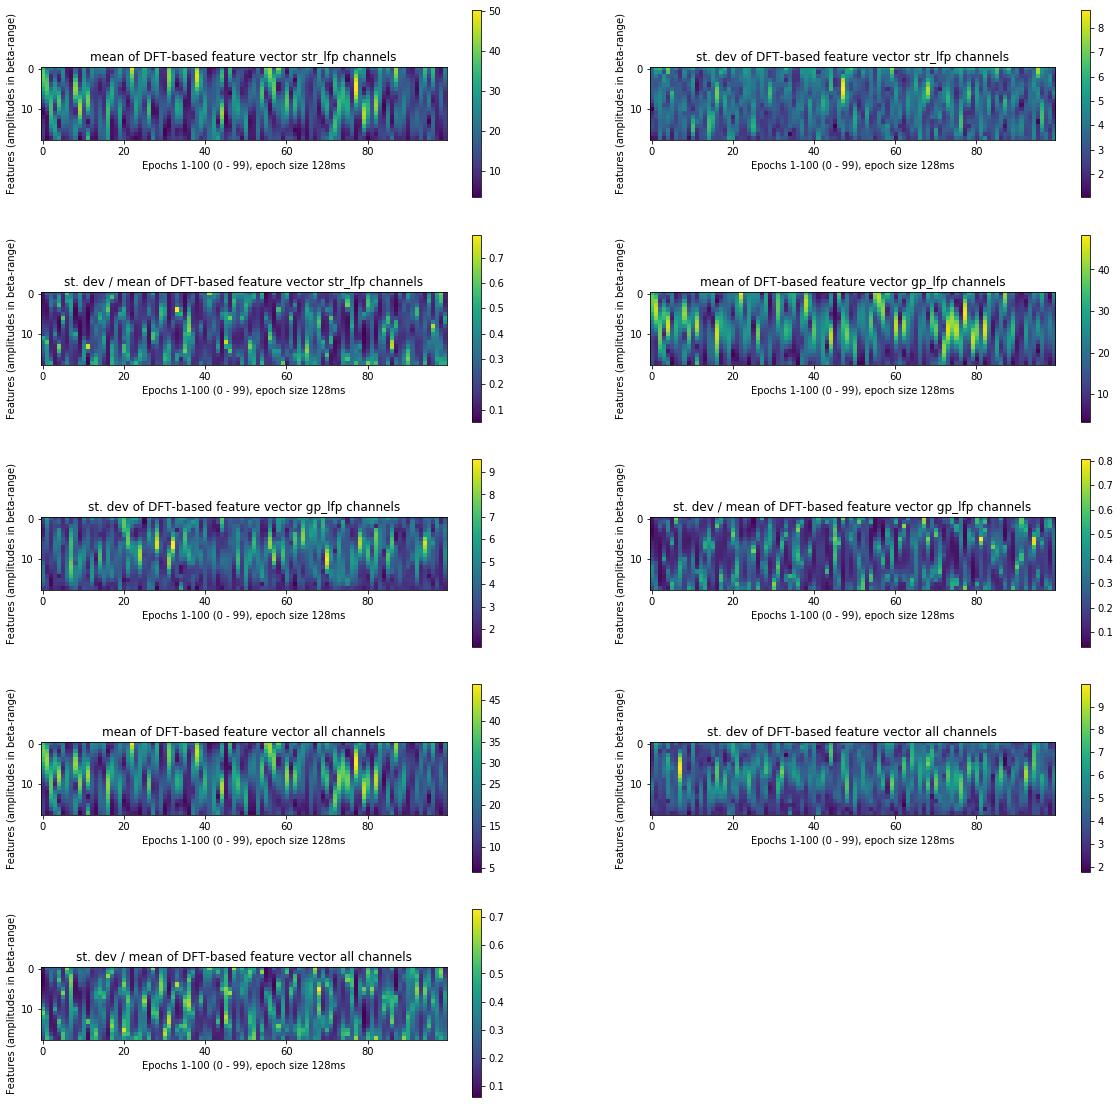

In [12]:
plt.clf()

plt.rcParams["figure.figsize"] = (20, 20)

matrixes = [
    mean_str, std_str, std_str / mean_str,
    mean_gp , std_gp , std_gp  / mean_gp ,
    mean_all, std_all, std_all / mean_all
]

types = [
    (channel_type, measurement)
    for channel_type in ["str_lfp", "gp_lfp", "all"]
    for measurement  in ["mean", "st. dev", "st. dev / mean"]
]

for matrix, (channel_type, measurement), index in zip(
    matrixes,
    types,
    range(1, 10)
):
    plt.subplot(5, 2, index)
    plt.imshow(matrix.transpose()[ : , 0 : 100])
    plt.colorbar()
    plt.title(measurement + " of DFT-based feature vector " + channel_type + " channels")
    plt.xlabel("Epochs 1-100 (0 - 99), epoch size " + str(int(epoch_size / Fs * 1000)) + "ms")
    plt.ylabel("Features (amplitudes in beta-range)")

The perhaps most important measurement in these examples is standard deviation over mean. Optimally, we would have liked standard deviation to be low, and standard deviation over mean to be very low.

If the standard deviation is proportionally large compared to the mean, that means that for that particular epoch and feature, there's high variance. While the data isn't normal-distributed, heuristically we might like to think "most values fall within two standard deviations". If the standard deviation is then 70% of the mean, we can't conclusively say much about that particular feature and epoch.

We are also interested in comparissons of the measures above.

Let's consider other perspectives.

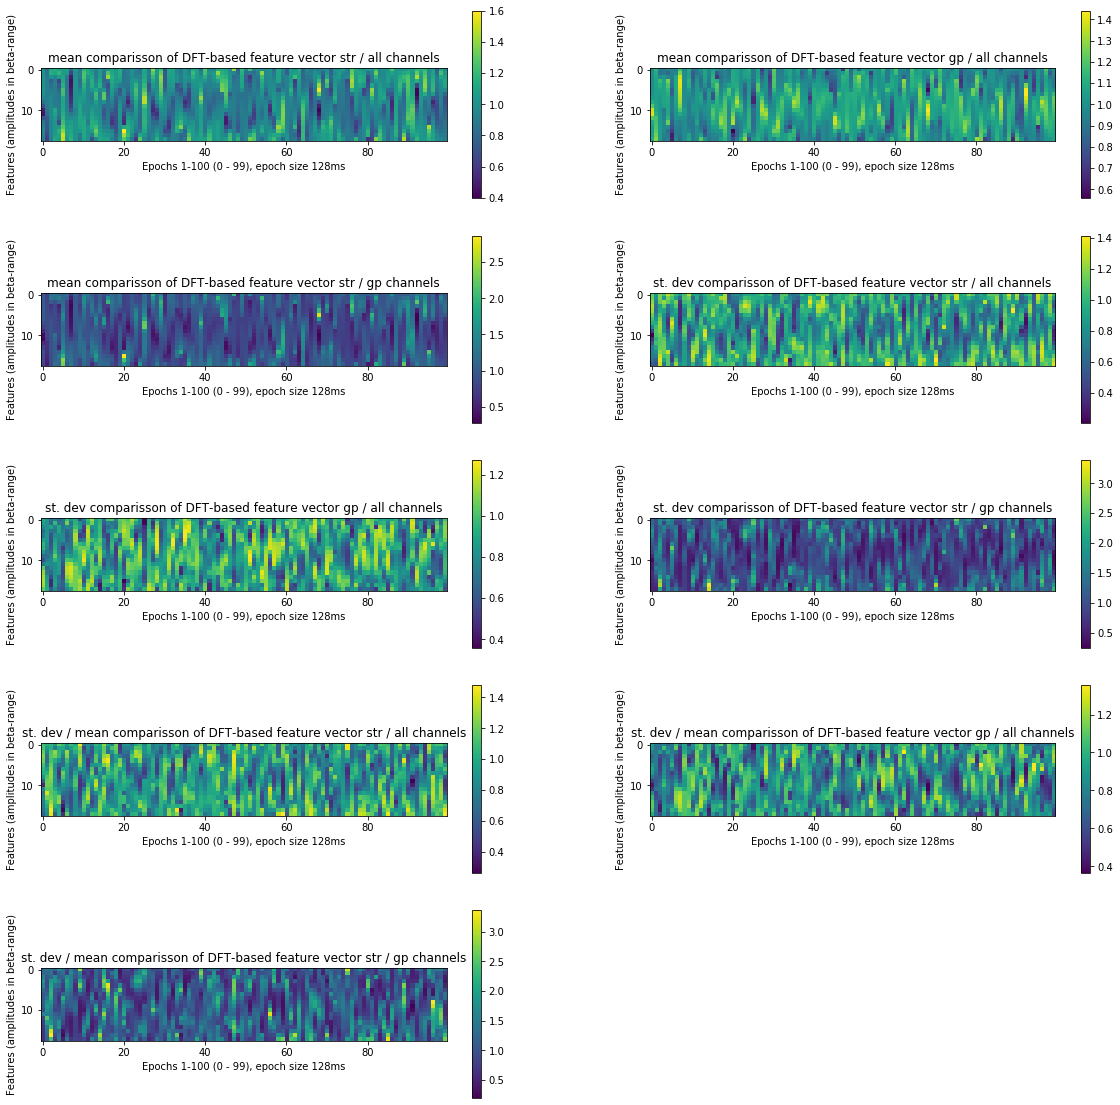

In [13]:
plt.clf()

matrixes = [
    # How different is the average activity?
    mean_str / mean_all, mean_gp / mean_all, mean_str / mean_gp,
    # How different are the standard deviations?
    std_str / std_all, std_gp / std_all, std_str / std_gp,
    # How different are the standard deviations over means?
    (std_str / mean_str) / (std_all / mean_all),
    (std_gp  / mean_gp ) / (std_all / mean_all),
    (std_str / mean_str) / (std_gp  / mean_gp )
]

types = [
    (channel_types, measurement)
    for measurement   in ["mean comparisson", "st. dev comparisson", "st. dev / mean comparisson"]
    for channel_types in ["str / all", "gp / all", "str / gp"]
]

for matrix, (channel_types, measurement), index in zip(
    matrixes,
    types,
    range(1, 10)
):
    plt.subplot(5, 2, index)
    plt.imshow(matrix.transpose()[ : , 0 : 100])
    plt.colorbar()
    plt.title(measurement + " of DFT-based feature vector " + channel_types + " channels")
    plt.xlabel("Epochs 1-100 (0 - 99), epoch size " + str(int(epoch_size / Fs * 1000)) + "ms")
    plt.ylabel("Features (amplitudes in beta-range)")

#### Closer to 1 means closer to equal - higher synchronization.
Many data points are very close to 1. Consider "average datapoint" from above plots.

In [14]:
for matrix, (chans, measurement) in zip(matrixes, types):
    print("##### " + chans + " channels " + measurement)
    print()
    print("Mean (all matrix values)\t\t\t" + str(matrix.mean()))
    print("Standard deviation (all matrix values)\t\t" + str(matrix.std()))
    print("+/- 2 sigma range:\t\t\t\t[" + 
          str( matrix.mean() - 2 * matrix.std() ) + ", " + 
          str( matrix.mean() + 2 * matrix.std() ) + "]")
    print()

##### str / all channels mean comparisson

Mean (all matrix values)			0.9713391919931631
Standard deviation (all matrix values)		0.156699867651732
+/- 2 sigma range:				[0.6579394566896991, 1.284738927296627]

##### gp / all channels mean comparisson

Mean (all matrix values)			1.0210179258716803
Standard deviation (all matrix values)		0.11491323627793679
+/- 2 sigma range:				[0.7911914533158066, 1.250844398427554]

##### str / gp channels mean comparisson

Mean (all matrix values)			0.9828585398542431
Standard deviation (all matrix values)		0.2862774882874409
+/- 2 sigma range:				[0.41030356327936135, 1.555413516429125]

##### str / all channels st. dev comparisson

Mean (all matrix values)			0.8666071726694271
Standard deviation (all matrix values)		0.22809148311201022
+/- 2 sigma range:				[0.41042420644540667, 1.3227901388934475]

##### gp / all channels st. dev comparisson

Mean (all matrix values)			0.8962684136037918
Standard deviation (all matrix values)		0.19092460825538873


#### Mean datapoint for most of these close (or very close) to 1. Variance high. Heuristic +/- 2 st. dev. gives large intervalls.

In [15]:
def mean_absolute_deviation(matrx):
    return np.abs( matrx - matrx.mean() ).mean()
def median_absolute_deviation(matrx):
    return np.median( np.abs( matrx - matrx.mean() ) )

for matrix, (chans, measurement) in zip(matrixes, types):
    print("##### " + chans + " channels " + measurement)
    print()
    print("Mean (all matrix values)\t\t\t" + str(matrix.mean()))
    print("Mean absolute deviation (all matrix values)\t" + str(mean_absolute_deviation(matrix)))
    print("Median absolute deviation (all matrix values)\t" + str(median_absolute_deviation(matrix)))
    print()

##### str / all channels mean comparisson

Mean (all matrix values)			0.9713391919931631
Mean absolute deviation (all matrix values)	0.12006917462795814
Median absolute deviation (all matrix values)	0.09233975259830995

##### gp / all channels mean comparisson

Mean (all matrix values)			1.0210179258716803
Mean absolute deviation (all matrix values)	0.08805072806050264
Median absolute deviation (all matrix values)	0.0677158185720938

##### str / gp channels mean comparisson

Mean (all matrix values)			0.9828585398542431
Mean absolute deviation (all matrix values)	0.20898739905254476
Median absolute deviation (all matrix values)	0.1589075787491635

##### str / all channels st. dev comparisson

Mean (all matrix values)			0.8666071726694271
Mean absolute deviation (all matrix values)	0.18704213758120347
Median absolute deviation (all matrix values)	0.16730835910603076

##### gp / all channels st. dev comparisson

Mean (all matrix values)			0.8962684136037918
Mean absolute deviation (all m

#### Mean/median absolute deviation from mean still high.